<a href="https://www.kaggle.com/code/javihm77/catboost-baseline-chapu-optuna?scriptVersionId=134177674" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Catboost Baseline

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-student-performance-from-game-play/sample_submission.csv
/kaggle/input/predict-student-performance-from-game-play/train_labels.csv
/kaggle/input/predict-student-performance-from-game-play/train.csv
/kaggle/input/predict-student-performance-from-game-play/test.csv
/kaggle/input/predict-student-performance-from-game-play/jo_wilder_310/competition.cpython-310-x86_64-linux-gnu.so
/kaggle/input/predict-student-performance-from-game-play/jo_wilder_310/__init__.py
/kaggle/input/predict-student-performance-from-game-play/jo_wilder/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/predict-student-performance-from-game-play/jo_wilder/__init__.py


In [2]:
import polars as pl
import gc
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import GroupKFold, KFold
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt
import warnings
from itertools import combinations
import math
from time import sleep
import pickle
import optuna
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Reading Files

In [3]:
targets = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]))
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]))

In [4]:
columns = [
    pl.col("page").cast(pl.Float32),
    (
        (pl.col("elapsed_time") - pl.col("elapsed_time").shift(1))
        .fill_null(0)
        .clip(0, 1e9)
        .over(["session_id", "level"])
        .alias("elapsed_time_diff")
    ),
    (
        (pl.col("screen_coor_x") - pl.col("screen_coor_x").shift(1))
        .abs()
        .over(["session_id", "level"])
    ),
    (
        (pl.col("screen_coor_y") - pl.col("screen_coor_y").shift(1))
        .abs()
        .over(["session_id", "level"])
    ) ,
    pl.col("fqid").fill_null("fqid_None"),
    pl.col("text_fqid").fill_null("text_fqid_None")

]

In [5]:
dtypes = {"session_id": pl.Int64,
          "elapsed_time": pl.Int64,
          "event_name": pl.Categorical,
          "name": pl.Categorical,
          "level": pl.Int8,
          "page": pl.Float32,
          "room_coor_x": pl.Float32,
          "room_coor_y": pl.Float32,
          "screen_coor_x": pl.Float32,
          "screen_coor_y": pl.Float32,
          "hover_duration": pl.Float32,
          "fqid": pl.Categorical,
          "room_fqid": pl.Categorical,
          "fullscreen": pl.Int8,
          "hq": pl.Int8,
          "music": pl.Int8,
          "level_group": pl.Categorical
          }

In [6]:
pl.toggle_string_cache(True)

In [7]:
%%time

train = (pl.read_csv('/kaggle/input/predict-student-performance-from-game-play/train.csv',dtypes=dtypes)
                .drop(["fullscreen", "hq", "music"])
                .with_columns(columns)
        )

CPU times: user 47 s, sys: 18.7 s, total: 1min 5s
Wall time: 59.8 s


# Reducing training file

In [8]:
def reduce_memory_usage_pl(df, name):
    """ Reduce memory usage by polars dataframe {df} with name {name} by changing its data types.
        Original pandas version of this function: https://www.kaggle.com/code/arjanso/reducing-dataframe-memory-size-by-65 """
    print(f"Memory usage of dataframe {name} is {round(df.estimated_size('mb'), 2)} MB")
    Numeric_Int_types = [pl.Int8,pl.Int16,pl.Int32,pl.Int64]
    Numeric_Float_types = [pl.Float32,pl.Float64]    
    for col in df.columns:
        col_type = df[col].dtype
        c_min = df[col].min()
        c_max = df[col].max()
        if col_type in Numeric_Int_types:
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df = df.with_columns(df[col].cast(pl.Int8))
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df = df.with_columns(df[col].cast(pl.Int16))
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df = df.with_columns(df[col].cast(pl.Int32))
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                df = df.with_columns(df[col].cast(pl.Int64))
        elif col_type in Numeric_Float_types:
            if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df = df.with_columns(df[col].cast(pl.Float32))
            else:
                pass
        elif col_type == pl.Utf8:
            df = df.with_columns(df[col].cast(pl.Categorical))
        else:
            pass
    
    print(f"Memory usage of dataframe {name} became {round(df.estimated_size('mb'), 2)} MB")
    return df

In [9]:
# Reducing polar
train = reduce_memory_usage_pl(train, "train_subset")

Memory usage of dataframe train_subset is 3264.77 MB
Memory usage of dataframe train_subset became 1802.58 MB


In [10]:
df1 = train.filter(pl.col("level_group")=='0-4')
df2 = train.filter(pl.col("level_group")=='5-12')
df3 = train.filter(pl.col("level_group")=='13-22')
df1.shape,df2.shape,df3.shape

((3981005, 18), (8844238, 18), (13471703, 18))

In [11]:
df3.head(8)

session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,level_group,elapsed_time_diff
i64,i16,i32,cat,cat,i8,f32,f32,f32,f32,f32,f32,cat,cat,cat,cat,cat,i32
20090312431273200,512,836732,"""navigate_click…","""undefined""",13,null,290.153564,-204.499359,null,null,null,null,"""fqid_None""","""tunic.capitol_…","""text_fqid_None…","""13-22""",0
20090312431273200,513,837245,"""navigate_click…","""undefined""",13,null,353.805603,-210.332062,21.0,0.0,null,null,"""fqid_None""","""tunic.capitol_…","""text_fqid_None…","""13-22""",513
20090312431273200,514,837779,"""navigate_click…","""undefined""",13,null,587.680054,-280.706238,108.0,44.0,null,null,"""fqid_None""","""tunic.capitol_…","""text_fqid_None…","""13-22""",534
20090312431273200,515,838446,"""navigate_click…","""undefined""",13,null,751.496887,-102.15329,43.0,124.0,null,null,"""toentry""","""tunic.capitol_…","""text_fqid_None…","""13-22""",667
20090312431273200,516,839629,"""map_hover""","""basic""",13,null,null,null,null,null,67.0,null,"""tunic.dryclean…","""tunic.capitol_…","""text_fqid_None…","""13-22""",1183
20090312431273200,517,840662,"""map_hover""","""basic""",13,null,null,null,null,null,983.0,null,"""tunic.dryclean…","""tunic.capitol_…","""text_fqid_None…","""13-22""",1033
20090312431273200,518,840780,"""map_hover""","""basic""",13,null,null,null,null,null,100.0,null,"""tunic.historic…","""tunic.capitol_…","""text_fqid_None…","""13-22""",118
20090312431273200,519,840830,"""map_hover""","""basic""",13,null,null,null,null,null,35.0,null,"""tunic.capitol_…","""tunic.capitol_…","""text_fqid_None…","""13-22""",50


In [12]:
#Delete train to liberate memory
del train
gc.collect()

30

# Feature Engineering

In [13]:
CATS = ['event_name', 'name', 'fqid', 'room_fqid', 'text_fqid']
NUMS = ['page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',
        'hover_duration', 'elapsed_time_diff']

fqid_lists = ['worker', 'archivist', 'gramps', 'wells', 'toentry', 'confrontation', 'crane_ranger', 'groupconvo', 'flag_girl', 'tomap', 'tostacks', 'tobasement', 'archivist_glasses', 'boss', 'journals', 'seescratches', 'groupconvo_flag', 'cs', 'teddy', 'expert', 'businesscards', 'ch3start', 'tunic.historicalsociety', 'tofrontdesk', 'savedteddy', 'plaque', 'glasses', 'tunic.drycleaner', 'reader_flag', 'tunic.library', 'tracks', 'tunic.capitol_2', 'trigger_scarf', 'reader', 'directory', 'tunic.capitol_1', 'journals.pic_0.next', 'unlockdoor', 'tunic', 'what_happened', 'tunic.kohlcenter', 'tunic.humanecology', 'colorbook', 'logbook', 'businesscards.card_0.next', 'journals.hub.topics', 'logbook.page.bingo', 'journals.pic_1.next', 'journals_flag', 'reader.paper0.next', 'tracks.hub.deer', 'reader_flag.paper0.next', 'trigger_coffee', 'wellsbadge', 'journals.pic_2.next', 'tomicrofiche', 'journals_flag.pic_0.bingo', 'plaque.face.date', 'notebook', 'tocloset_dirty', 'businesscards.card_bingo.bingo', 'businesscards.card_1.next', 'tunic.wildlife', 'tunic.hub.slip', 'tocage', 'journals.pic_2.bingo', 'tocollectionflag', 'tocollection', 'chap4_finale_c', 'chap2_finale_c', 'lockeddoor', 'journals_flag.hub.topics', 'tunic.capitol_0', 'reader_flag.paper2.bingo', 'photo', 'tunic.flaghouse', 'reader.paper1.next', 'directory.closeup.archivist', 'intro', 'businesscards.card_bingo.next', 'reader.paper2.bingo', 'retirement_letter', 'remove_cup', 'journals_flag.pic_0.next', 'magnify', 'coffee', 'key', 'togrampa', 'reader_flag.paper1.next', 'janitor', 'tohallway', 'chap1_finale', 'report', 'outtolunch', 'journals_flag.hub.topics_old', 'journals_flag.pic_1.next', 'reader.paper2.next', 'chap1_finale_c', 'reader_flag.paper2.next', 'door_block_talk', 'journals_flag.pic_1.bingo', 'journals_flag.pic_2.next', 'journals_flag.pic_2.bingo', 'block_magnify', 'reader.paper0.prev', 'block', 'reader_flag.paper0.prev', 'block_0', 'door_block_clean', 'reader.paper2.prev', 'reader.paper1.prev', 'doorblock', 'tocloset', 'reader_flag.paper2.prev', 'reader_flag.paper1.prev', 'block_tomap2', 'journals_flag.pic_0_old.next', 'journals_flag.pic_1_old.next', 'block_tocollection', 'block_nelson', 'journals_flag.pic_2_old.next', 'block_tomap1', 'block_badge', 'need_glasses', 'block_badge_2', 'fox', 'block_1']
DIALOGS = ['that', 'this', 'it', 'you','find','found','Found','notebook','Wells','wells','help','need', 'Oh','Ooh','Jo', 'flag', 'can','and','is','the','to']

name_feature = ['basic', 'undefined', 'close', 'open', 'prev', 'next']
event_name_feature = ['cutscene_click', 'person_click', 'navigate_click',
       'observation_click', 'notification_click', 'object_click',
       'object_hover', 'map_hover', 'map_click', 'checkpoint',
       'notebook_click']

text_lists = ['tunic.historicalsociety.cage.confrontation', 'tunic.wildlife.center.crane_ranger.crane', 'tunic.historicalsociety.frontdesk.archivist.newspaper', 'tunic.historicalsociety.entry.groupconvo', 'tunic.wildlife.center.wells.nodeer', 'tunic.historicalsociety.frontdesk.archivist.have_glass', 'tunic.drycleaner.frontdesk.worker.hub', 'tunic.historicalsociety.closet_dirty.gramps.news', 'tunic.humanecology.frontdesk.worker.intro', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation', 'tunic.historicalsociety.basement.seescratches', 'tunic.historicalsociety.collection.cs', 'tunic.flaghouse.entry.flag_girl.hello', 'tunic.historicalsociety.collection.gramps.found', 'tunic.historicalsociety.basement.ch3start', 'tunic.historicalsociety.entry.groupconvo_flag', 'tunic.library.frontdesk.worker.hello', 'tunic.library.frontdesk.worker.wells', 'tunic.historicalsociety.collection_flag.gramps.flag', 'tunic.historicalsociety.basement.savedteddy', 'tunic.library.frontdesk.worker.nelson', 'tunic.wildlife.center.expert.removed_cup', 'tunic.library.frontdesk.worker.flag', 'tunic.historicalsociety.frontdesk.archivist.hello', 'tunic.historicalsociety.closet.gramps.intro_0_cs_0', 'tunic.historicalsociety.entry.boss.flag', 'tunic.flaghouse.entry.flag_girl.symbol', 'tunic.historicalsociety.closet_dirty.trigger_scarf', 'tunic.drycleaner.frontdesk.worker.done', 'tunic.historicalsociety.closet_dirty.what_happened', 'tunic.wildlife.center.wells.animals', 'tunic.historicalsociety.closet.teddy.intro_0_cs_0', 'tunic.historicalsociety.cage.glasses.afterteddy', 'tunic.historicalsociety.cage.teddy.trapped', 'tunic.historicalsociety.cage.unlockdoor', 'tunic.historicalsociety.stacks.journals.pic_2.bingo', 'tunic.historicalsociety.entry.wells.flag', 'tunic.humanecology.frontdesk.worker.badger', 'tunic.historicalsociety.stacks.journals_flag.pic_0.bingo', 'tunic.historicalsociety.closet.intro', 'tunic.historicalsociety.closet.retirement_letter.hub', 'tunic.historicalsociety.entry.directory.closeup.archivist', 'tunic.historicalsociety.collection.tunic.slip', 'tunic.kohlcenter.halloffame.plaque.face.date', 'tunic.historicalsociety.closet_dirty.trigger_coffee', 'tunic.drycleaner.frontdesk.logbook.page.bingo', 'tunic.library.microfiche.reader.paper2.bingo', 'tunic.kohlcenter.halloffame.togrampa', 'tunic.capitol_2.hall.boss.haveyougotit', 'tunic.wildlife.center.wells.nodeer_recap', 'tunic.historicalsociety.cage.glasses.beforeteddy', 'tunic.historicalsociety.closet_dirty.gramps.helpclean', 'tunic.wildlife.center.expert.recap', 'tunic.historicalsociety.frontdesk.archivist.have_glass_recap', 'tunic.historicalsociety.stacks.journals_flag.pic_1.bingo', 'tunic.historicalsociety.cage.lockeddoor', 'tunic.historicalsociety.stacks.journals_flag.pic_2.bingo', 'tunic.historicalsociety.collection.gramps.lost', 'tunic.historicalsociety.closet.notebook', 'tunic.historicalsociety.frontdesk.magnify', 'tunic.humanecology.frontdesk.businesscards.card_bingo.bingo', 'tunic.wildlife.center.remove_cup', 'tunic.library.frontdesk.wellsbadge.hub', 'tunic.wildlife.center.tracks.hub.deer', 'tunic.historicalsociety.frontdesk.key', 'tunic.library.microfiche.reader_flag.paper2.bingo', 'tunic.flaghouse.entry.colorbook', 'tunic.wildlife.center.coffee', 'tunic.capitol_1.hall.boss.haveyougotit', 'tunic.historicalsociety.basement.janitor', 'tunic.historicalsociety.collection_flag.gramps.recap', 'tunic.wildlife.center.wells.animals2', 'tunic.flaghouse.entry.flag_girl.symbol_recap', 'tunic.historicalsociety.closet_dirty.photo', 'tunic.historicalsociety.stacks.outtolunch', 'tunic.library.frontdesk.worker.wells_recap', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap', 'tunic.capitol_0.hall.boss.talktogramps', 'tunic.historicalsociety.closet.photo', 'tunic.historicalsociety.collection.tunic', 'tunic.historicalsociety.closet.teddy.intro_0_cs_5', 'tunic.historicalsociety.closet_dirty.gramps.archivist', 'tunic.historicalsociety.closet_dirty.door_block_talk', 'tunic.historicalsociety.entry.boss.flag_recap', 'tunic.historicalsociety.frontdesk.archivist.need_glass_0', 'tunic.historicalsociety.entry.wells.talktogramps', 'tunic.historicalsociety.frontdesk.block_magnify', 'tunic.historicalsociety.frontdesk.archivist.foundtheodora', 'tunic.historicalsociety.closet_dirty.gramps.nothing', 'tunic.historicalsociety.closet_dirty.door_block_clean', 'tunic.capitol_1.hall.boss.writeitup', 'tunic.library.frontdesk.worker.nelson_recap', 'tunic.library.frontdesk.worker.hello_short', 'tunic.historicalsociety.stacks.block', 'tunic.historicalsociety.frontdesk.archivist.need_glass_1', 'tunic.historicalsociety.entry.boss.talktogramps', 'tunic.historicalsociety.frontdesk.archivist.newspaper_recap', 'tunic.historicalsociety.entry.wells.flag_recap', 'tunic.drycleaner.frontdesk.worker.done2', 'tunic.library.frontdesk.worker.flag_recap', 'tunic.humanecology.frontdesk.block_0', 'tunic.library.frontdesk.worker.preflag', 'tunic.historicalsociety.basement.gramps.seeyalater', 'tunic.flaghouse.entry.flag_girl.hello_recap', 'tunic.historicalsociety.closet.doorblock', 'tunic.drycleaner.frontdesk.worker.takealook', 'tunic.historicalsociety.basement.gramps.whatdo', 'tunic.library.frontdesk.worker.droppedbadge', 'tunic.historicalsociety.entry.block_tomap2', 'tunic.library.frontdesk.block_nelson', 'tunic.library.microfiche.block_0', 'tunic.historicalsociety.entry.block_tocollection', 'tunic.historicalsociety.entry.block_tomap1', 'tunic.historicalsociety.collection.gramps.look_0', 'tunic.library.frontdesk.block_badge', 'tunic.historicalsociety.cage.need_glasses', 'tunic.library.frontdesk.block_badge_2', 'tunic.kohlcenter.halloffame.block_0', 'tunic.capitol_0.hall.chap1_finale_c', 'tunic.capitol_1.hall.chap2_finale_c', 'tunic.capitol_2.hall.chap4_finale_c', 'tunic.wildlife.center.fox.concern', 'tunic.drycleaner.frontdesk.block_0', 'tunic.historicalsociety.entry.gramps.hub', 'tunic.humanecology.frontdesk.block_1', 'tunic.drycleaner.frontdesk.block_1']
room_lists = ['tunic.historicalsociety.entry', 'tunic.wildlife.center', 'tunic.historicalsociety.cage', 'tunic.library.frontdesk', 'tunic.historicalsociety.frontdesk', 'tunic.historicalsociety.stacks', 'tunic.historicalsociety.closet_dirty', 'tunic.humanecology.frontdesk', 'tunic.historicalsociety.basement', 'tunic.kohlcenter.halloffame', 'tunic.library.microfiche', 'tunic.drycleaner.frontdesk', 'tunic.historicalsociety.collection', 'tunic.historicalsociety.closet', 'tunic.flaghouse.entry', 'tunic.historicalsociety.collection_flag', 'tunic.capitol_1.hall', 'tunic.capitol_0.hall', 'tunic.capitol_2.hall']

LEVELS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
level_groups = ["0-4", "5-12", "13-22"]

In [14]:
def feature_engineer(x, grp, use_extra, feature_suffix):
    aggs = [
        pl.col("index").count().alias(f"session_number_{feature_suffix}"),

        *[pl.col(c).drop_nulls().n_unique().alias(f"{c}_unique_{feature_suffix}") for c in CATS],

        *[pl.col(c).std().alias(f"{c}_std_{feature_suffix}") for c in NUMS],
        *[pl.col(c).mean().alias(f"{c}_mean_{feature_suffix}") for c in NUMS],
        *[pl.col(c).min().alias(f"{c}_min_{feature_suffix}") for c in NUMS],
        *[pl.col(c).max().alias(f"{c}_max_{feature_suffix}") for c in NUMS],
        *[pl.col(c).sum().alias(f"{c}_sum_{feature_suffix}") for c in NUMS],

        *[pl.col("fqid").filter(pl.col("fqid") == c).count().alias(f"{c}_fqid_counts{feature_suffix}")
          for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for
          c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for
          c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for
          c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for
          c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
          c in fqid_lists],


        *[pl.col("text_fqid").filter(pl.col("text_fqid") == c).count().alias(f"{c}_text_fqid_counts{feature_suffix}") for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
          c in text_lists],

        *[pl.col("room_fqid").filter(pl.col("room_fqid") == c).count().alias(f"{c}_room_fqid_counts{feature_suffix}")
          for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for
          c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for
          c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for
          c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for
          c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
          c in room_lists],

        *[pl.col("event_name").filter(pl.col("event_name") == c).count().alias(f"{c}_event_name_counts{feature_suffix}")
          for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).std().alias(f"{c}_ET_std_{feature_suffix}")for
          c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for
          c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for
          c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for
          c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
          c in event_name_feature],

        *[pl.col("name").filter(pl.col("name") == c).count().alias(f"{c}_name_counts{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in
          name_feature],

        *[pl.col("level").filter(pl.col("level") == c).count().alias(f"{c}_LEVEL_count{feature_suffix}") for c in LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in
          LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in
          LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in
          LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for c in
          LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in
          LEVELS],

        *[pl.col("level_group").filter(pl.col("level_group") == c).count().alias(f"{c}_LEVEL_group_count{feature_suffix}") for c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in
          level_groups],

        *[pl.col("index").filter((pl.col("level") == c) & (pl.col('room_fqid') == d)).count().alias(f"{c}{d}_level_room_count{feature_suffix}") for c in LEVELS for d in room_lists],


    ]

    df = x.groupby(['session_id'], maintain_order=True).agg(aggs).sort("session_id")

    if use_extra:
        if grp == '5-12':
            aggs = [
                pl.col("elapsed_time").filter((pl.col("text")=="Here's the log book.")
                                              |(pl.col("fqid")=='logbook.page.bingo'))
                    .apply(lambda s: s.max()-s.min()).alias("logbook_bingo_duration"),
                pl.col("index").filter(
                    (pl.col("text") == "Here's the log book.") | (pl.col("fqid") == 'logbook.page.bingo')).apply(
                    lambda s: s.max() - s.min()).alias("logbook_bingo_indexCount"),
                pl.col("elapsed_time").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'reader')) | (
                                pl.col("fqid") == "reader.paper2.bingo")).apply(lambda s: s.max() - s.min()).alias(
                    "reader_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'reader')) | (
                            pl.col("fqid") == "reader.paper2.bingo")).apply(lambda s: s.max() - s.min()).alias(
                    "reader_bingo_indexCount"),
                pl.col("elapsed_time").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'journals')) | (
                                pl.col("fqid") == "journals.pic_2.bingo")).apply(lambda s: s.max() - s.min()).alias(
                    "journals_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'journals')) | (
                            pl.col("fqid") == "journals.pic_2.bingo")).apply(lambda s: s.max() - s.min()).alias(
                    "journals_bingo_indexCount"),
            ]
            tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
            df = df.join(tmp, on="session_id", how='left')

        if grp == '13-22':
            aggs = [
                pl.col("elapsed_time").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'reader_flag')) | (
                                pl.col("fqid") == "tunic.library.microfiche.reader_flag.paper2.bingo")).apply(
                    lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("reader_flag_duration"),
                pl.col("index").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'reader_flag')) | (
                                pl.col("fqid") == "tunic.library.microfiche.reader_flag.paper2.bingo")).apply(
                    lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("reader_flag_indexCount"),
                pl.col("elapsed_time").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'journals_flag')) | (
                                pl.col("fqid") == "journals_flag.pic_0.bingo")).apply(
                    lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("journalsFlag_bingo_duration"),
                pl.col("index").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'journals_flag')) | (
                                pl.col("fqid") == "journals_flag.pic_0.bingo")).apply(
                    lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("journalsFlag_bingo_indexCount")
            ]
            tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
            df = df.join(tmp, on="session_id", how='left')

    return df.to_pandas()

In [15]:
%%time
df1 = feature_engineer(df1, grp='0-4', use_extra=True, feature_suffix='')

CPU times: user 11.4 s, sys: 865 ms, total: 12.2 s
Wall time: 6.44 s


In [16]:
%%time
df2 = feature_engineer(df2, grp='5-12', use_extra=True, feature_suffix='')

CPU times: user 30.8 s, sys: 1.03 s, total: 31.9 s
Wall time: 17 s


In [17]:
%%time
df3 = feature_engineer(df3, grp='13-22', use_extra=True, feature_suffix='')

CPU times: user 49.2 s, sys: 1.27 s, total: 50.5 s
Wall time: 26.4 s


In [18]:
df1.head(8)

session_id  session_number_  event_name_unique_  name_unique_  \
0  20090312431273200              165                  10             3   
1  20090312433251036              139                  11             4   
2  20090312455206810              149                   9             3   
3  20090313091715820              176                  11             4   
4  20090313571836404              112                  10             4   
5  20090314035813970              154                  11             4   
6  20090314121766812              165                  11             4   
7  20090314221187252              210                  11             4   

   fqid_unique_  room_fqid_unique_  text_fqid_unique_  page_std_  \
0            31                  7                 18        NaN   
1            23                  6                 12   0.000000   
2            23                  6                 13        NaN   
3            25                  6                 15   0.000000   
4            23                  6                 13   0.000000   
5            27                  6                 20   0.000000   
6            27                  7                 16   0.483046   
7            24                  6                 15   0.000000   

   room_coor_x_std_  room_coor_y_std_  screen_coor_x_std_  screen_coor_y_std_  \
0        399.296051        129.292404          144.538300           93.921089   
1        445.980042        156.186249          174.552185          111.039917   
2        478.652405        161.438385          236.266586          100.641541   
3        422.766418        161.696457          149.743561          138.407562   
4        452.898682        176.604691          228.544296          142.292816   
5        431.772400        209.019714          212.829010          143.533585   
6        418.706665        183.290268          206.542511          140.145752   
7        450.837097        157.648315          172.408798          103.397209   

   hover_duration_std_  elapsed_time_diff_std_  page_mean_  room_coor_x_mean_  \
0          3227.370850             2450.666690         NaN           7.701280   
1          2114.876465             3481.761026         0.0         -84.045975   
2          4575.148438            17276.513933         NaN        -209.830246   
3          1949.073608             3700.196651         0.0        -111.962715   
4          1743.134277             3101.735542         0.0          -5.028425   
5          5603.987793             5166.942039         0.0          25.017109   
6          2617.938232             5393.656977         0.3         125.841293   
7          1007.462158             2681.176129         0.0         -12.076721   

   room_coor_y_mean_  screen_coor_x_mean_  screen_coor_y_mean_  \
0         -71.413757            93.482758            61.151726   
1         -53.671074            92.588234            59.815125   
2         -31.125031            82.328468            36.029198   
3         -76.698105            76.403847            68.903847   
4          -1.624749           178.258072            97.408600   
5          20.786787           186.455887           104.683823   
6         -41.298328           153.765961           114.099289   
7         -51.486679            69.539680            40.449734   

   hover_duration_mean_  elapsed_time_diff_mean_  page_min_  room_coor_x_min_  \
0           2389.500000              1159.769697        NaN      -1013.383362   
1           1378.750000              1618.474820        0.0      -1112.320557   
2           3145.666748              2423.597315        NaN      -1017.030884   
3           1917.142822              1077.125000        0.0       -995.609070   
4           1580.714233              1682.937500        0.0       -918.020691   
5           5996.500000              2681.883117        0.0       -980.660522   
6           1603.400024              2348.975758        0.0       -951.492065   
7           1311.3

In [19]:
df1.shape

(23562, 2344)

In [20]:
def time_feature(train):
    train["year"] = train["session_id"].apply(lambda x: int(str(x)[:2])).astype(np.uint8)
    train["month"] = train["session_id"].apply(lambda x: int(str(x)[2:4])+1).astype(np.uint8)
    train["day"] = train["session_id"].apply(lambda x: int(str(x)[4:6])).astype(np.uint8)
    train["hour"] = train["session_id"].apply(lambda x: int(str(x)[6:8])).astype(np.uint8)
    train["minute"] = train["session_id"].apply(lambda x: int(str(x)[8:10])).astype(np.uint8)
    train["second"] = train["session_id"].apply(lambda x: int(str(x)[10:12])).astype(np.uint8)
    
    return train

In [21]:
df1 = time_feature(df1)
df2 = time_feature(df2)
df3 = time_feature(df3)

In [22]:
df1.head(8)

session_id  session_number_  event_name_unique_  name_unique_  \
0  20090312431273200              165                  10             3   
1  20090312433251036              139                  11             4   
2  20090312455206810              149                   9             3   
3  20090313091715820              176                  11             4   
4  20090313571836404              112                  10             4   
5  20090314035813970              154                  11             4   
6  20090314121766812              165                  11             4   
7  20090314221187252              210                  11             4   

   fqid_unique_  room_fqid_unique_  text_fqid_unique_  page_std_  \
0            31                  7                 18        NaN   
1            23                  6                 12   0.000000   
2            23                  6                 13        NaN   
3            25                  6                 15   0.000000   
4            23                  6                 13   0.000000   
5            27                  6                 20   0.000000   
6            27                  7                 16   0.483046   
7            24                  6                 15   0.000000   

   room_coor_x_std_  room_coor_y_std_  screen_coor_x_std_  screen_coor_y_std_  \
0        399.296051        129.292404          144.538300           93.921089   
1        445.980042        156.186249          174.552185          111.039917   
2        478.652405        161.438385          236.266586          100.641541   
3        422.766418        161.696457          149.743561          138.407562   
4        452.898682        176.604691          228.544296          142.292816   
5        431.772400        209.019714          212.829010          143.533585   
6        418.706665        183.290268          206.542511          140.145752   
7        450.837097        157.648315          172.408798          103.397209   

   hover_duration_std_  elapsed_time_diff_std_  page_mean_  room_coor_x_mean_  \
0          3227.370850             2450.666690         NaN           7.701280   
1          2114.876465             3481.761026         0.0         -84.045975   
2          4575.148438            17276.513933         NaN        -209.830246   
3          1949.073608             3700.196651         0.0        -111.962715   
4          1743.134277             3101.735542         0.0          -5.028425   
5          5603.987793             5166.942039         0.0          25.017109   
6          2617.938232             5393.656977         0.3         125.841293   
7          1007.462158             2681.176129         0.0         -12.076721   

   room_coor_y_mean_  screen_coor_x_mean_  screen_coor_y_mean_  \
0         -71.413757            93.482758            61.151726   
1         -53.671074            92.588234            59.815125   
2         -31.125031            82.328468            36.029198   
3         -76.698105            76.403847            68.903847   
4          -1.624749           178.258072            97.408600   
5          20.786787           186.455887           104.683823   
6         -41.298328           153.765961           114.099289   
7         -51.486679            69.539680            40.449734   

   hover_duration_mean_  elapsed_time_diff_mean_  page_min_  room_coor_x_min_  \
0           2389.500000              1159.769697        NaN      -1013.383362   
1           1378.750000              1618.474820        0.0      -1112.320557   
2           3145.666748              2423.597315        NaN      -1017.030884   
3           1917.142822              1077.125000        0.0       -995.609070   
4           1580.714233              1682.937500        0.0       -918.020691   
5           5996.500000              2681.883117        0.0       -980.660522   
6           1603.400024              2348.975758        0.0       -951.492065   
7           1311.3

In [23]:
df1.shape

(23562, 2350)

In [24]:
null1 = df1.isnull().sum().sort_values(ascending=False)/len(df1)
null2 = df2.isnull().sum().sort_values(ascending=False)/len(df2)
null3 = df3.isnull().sum().sort_values(ascending=False)/len(df3)

drop1 = list(null1[null1 > 0.7].index)
drop2 = list(null2[null2 > 0.7].index)
drop3 = list(null3[null3 > 0.7].index)

print(len(drop1), len(drop2), len(drop3))

for col in tqdm(df1.columns):
    if df1[col].nunique() == 1:
        #print(col)
        drop1.append(col)
        #sleep(0.1)
for col in tqdm(df2.columns):
    if df2[col].nunique() == 1:
        #print(col)
        drop2.append(col)
        #sleep(0.1)
for col in tqdm(df3.columns):
    if df3[col].nunique() == 1:
        #print(col)
        drop3.append(col)
        #sleep(0.1)

1225 1040 890


  0%|          | 0/2350 [00:00<?, ?it/s]

  0%|          | 0/2356 [00:00<?, ?it/s]

  0%|          | 0/2354 [00:00<?, ?it/s]

In [25]:
df1 = df1.set_index('session_id')
df2 = df2.set_index('session_id')
df3 = df3.set_index('session_id')

In [26]:
FEATURES1 = [c for c in df1.columns if c not in drop1+['level_group']]
FEATURES2 = [c for c in df2.columns if c not in drop2+['level_group']]
FEATURES3 = [c for c in df3.columns if c not in drop3+['level_group']]

print('We will train with', len(FEATURES1), len(FEATURES2), len(FEATURES3), 'features')
ALL_USERS = df1.index.unique()
print('We will train with', len(ALL_USERS), 'users info')

We will train with 487 787 1042 features
We will train with 23562 users info


# Optuna Parameters optimization

In [27]:
def objective(trial,X,y):
    
    train_x, valid_x, train_y, valid_y = train_test_split(X,y, test_size=0.3)
    
    cat_params = {
        "depth": trial.suggest_int("depth", 1, 9),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        'n_estimators': trial.suggest_int('n_estimators', 150, 750),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1),
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        'random_seed': 42,
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "used_ram_limit": "6gb",
        'eval_metric': 'AUC'
    }

    if cat_params["bootstrap_type"] == "Bayesian":
        cat_params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif cat_params["bootstrap_type"] == "Bernoulli":
        cat_params["subsample"] = trial.suggest_float("subsample", 0.1, 1)
        
    gbm = CatBoostClassifier(**cat_params,verbose=False)

    gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], early_stopping_rounds=50)

    preds = gbm.predict(valid_x)
    pred_labels = (preds > 0.62).astype('int')

    accuracy = accuracy_score(valid_y, pred_labels)
    
    return accuracy

In [28]:
# %%time

rf_best_params = []
studies = []

# ITERATE THRU QUESTIONS 1 THRU 18
for t in tqdm(range(1,19)): #1-19
        
    if t <= 3:
        grp = '0-4'
        df = df1
        FEATURES = FEATURES1
    elif t <= 13:
        grp = '5-12'
        df = df2
        FEATURES = FEATURES2
    elif t <= 22:
        grp = '13-22'
        df = df3
        FEATURES = FEATURES3

    print("")    
    print("*"*25)
    print(f'question{t}, with{len(FEATURES)}features')
    print('*'*25)
            
    # TRAIN DATA
    train_x = df[FEATURES]
    train_users = train_x.index.values
    train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
    
    # Wrap the objective inside a lambda and call objective inside it
    func = lambda trial: objective(trial, train_x, train_y['correct'])
    
    #Optuna 
    study = optuna.create_study(study_name=f"catboost_{t}",direction="maximize")
    study.optimize(func, n_trials=10, timeout=500)
    
    print(f'--- Model: {grp}_{t}')
    print('Number of finished trials:', len(study.trials))
    print('Best trial:', study.best_trial.params)
    print('Best value:', study.best_value)
    
    rf_best_params.append(study.best_trial.params)
    studies.append(study)
        
print("-"*80)


  0%|          | 0/18 [00:00<?, ?it/s]


*************************
question1, with487features
*************************


[I 2023-06-19 23:48:20,376] A new study created in memory with name: catboost_1
[I 2023-06-19 23:48:24,874] Trial 0 finished with value: 0.7390012731645211 and parameters: {'depth': 5, 'bootstrap_type': 'Bayesian', 'n_estimators': 236, 'learning_rate': 0.00011514219674755342, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.10948673334874191, 'min_data_in_leaf': 79, 'bagging_temperature': 3.7805862532385137}. Best is trial 0 with value: 0.7390012731645211.
[I 2023-06-19 23:48:35,668] Trial 1 finished with value: 0.740557363134814 and parameters: {'depth': 8, 'bootstrap_type': 'Bernoulli', 'n_estimators': 391, 'learning_rate': 0.001934356731681207, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.23103596520126135, 'min_data_in_leaf': 22, 'subsample': 0.6895718294673233}. Best is trial 1 with value: 0.740557363134814.
[I 2023-06-19 23:49:04,945] Trial 2 finished with value: 0.7408402885839581 and parameters: {'depth': 6, 'bootstrap_type': 'MVS', 'n_estimators': 341, 'learning_rate

--- Model: 0-4_1
Number of finished trials: 10
Best trial: {'depth': 8, 'bootstrap_type': 'Bernoulli', 'n_estimators': 595, 'learning_rate': 0.040995517844282965, 'objective': 'Logloss', 'colsample_bylevel': 0.8985259721446854, 'min_data_in_leaf': 99, 'subsample': 0.9280883769387885}
Best value: 0.7530060828971566

*************************
question2, with487features
*************************


[I 2023-06-19 23:53:58,581] Trial 0 finished with value: 0.981043994907342 and parameters: {'depth': 7, 'bootstrap_type': 'Bernoulli', 'n_estimators': 344, 'learning_rate': 0.0006607521808005521, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.6611311718799489, 'min_data_in_leaf': 81, 'subsample': 0.42654845425538157}. Best is trial 0 with value: 0.981043994907342.
[I 2023-06-19 23:54:07,022] Trial 1 finished with value: 0.9779318149667563 and parameters: {'depth': 6, 'bootstrap_type': 'Bayesian', 'n_estimators': 466, 'learning_rate': 0.0006186759569261492, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.21734612586678642, 'min_data_in_leaf': 69, 'bagging_temperature': 7.135549839039911}. Best is trial 0 with value: 0.981043994907342.
[I 2023-06-19 23:54:10,191] Trial 2 finished with value: 0.9782147404159004 and parameters: {'depth': 3, 'bootstrap_type': 'MVS', 'n_estimators': 564, 'learning_rate': 0.9350419315910408, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.7352291

--- Model: 0-4_2
Number of finished trials: 10
Best trial: {'depth': 7, 'bootstrap_type': 'Bernoulli', 'n_estimators': 344, 'learning_rate': 0.0006607521808005521, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.6611311718799489, 'min_data_in_leaf': 81, 'subsample': 0.42654845425538157}
Best value: 0.981043994907342

*************************
question3, with487features
*************************


[I 2023-06-19 23:59:43,473] Trial 0 finished with value: 0.932239354929976 and parameters: {'depth': 9, 'bootstrap_type': 'Bayesian', 'n_estimators': 210, 'learning_rate': 0.003360576621112543, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.8644528026869037, 'min_data_in_leaf': 94, 'bagging_temperature': 1.0826805455121646}. Best is trial 0 with value: 0.932239354929976.
[I 2023-06-20 00:02:04,099] Trial 1 finished with value: 0.9326637431036922 and parameters: {'depth': 9, 'bootstrap_type': 'Bernoulli', 'n_estimators': 630, 'learning_rate': 0.05969168556811352, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.9659214514681509, 'min_data_in_leaf': 82, 'subsample': 0.5778785242891911}. Best is trial 1 with value: 0.9326637431036922.
[I 2023-06-20 00:02:11,908] Trial 2 finished with value: 0.9349271466968454 and parameters: {'depth': 6, 'bootstrap_type': 'Bernoulli', 'n_estimators': 468, 'learning_rate': 0.04773617770776213, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.056

--- Model: 0-4_3
Number of finished trials: 10
Best trial: {'depth': 9, 'bootstrap_type': 'Bayesian', 'n_estimators': 554, 'learning_rate': 0.00150757098822292, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.06754592785172939, 'min_data_in_leaf': 43, 'bagging_temperature': 9.643366412719123}
Best value: 0.9364832366671382

*************************
question4, with787features
*************************


[I 2023-06-20 00:05:23,018] A new study created in memory with name: catboost_4
[I 2023-06-20 00:05:33,677] Trial 0 finished with value: 0.8165228462300184 and parameters: {'depth': 5, 'bootstrap_type': 'MVS', 'n_estimators': 206, 'learning_rate': 0.3577616383033607, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.8577158281704168, 'min_data_in_leaf': 17}. Best is trial 0 with value: 0.8165228462300184.
[I 2023-06-20 00:05:41,948] Trial 1 finished with value: 0.8040741264676757 and parameters: {'depth': 3, 'bootstrap_type': 'Bayesian', 'n_estimators': 252, 'learning_rate': 0.0001086264667128912, 'objective': 'Logloss', 'colsample_bylevel': 0.7538216408463133, 'min_data_in_leaf': 7, 'bagging_temperature': 1.704937594927326}. Best is trial 0 with value: 0.8165228462300184.
[I 2023-06-20 00:05:52,599] Trial 2 finished with value: 0.8172301598528787 and parameters: {'depth': 2, 'bootstrap_type': 'Bayesian', 'n_estimators': 586, 'learning_rate': 0.03725414826145442, 'objective': 'CrossE

--- Model: 5-12_4
Number of finished trials: 10
Best trial: {'depth': 6, 'bootstrap_type': 'Bayesian', 'n_estimators': 631, 'learning_rate': 0.022903670625336627, 'objective': 'Logloss', 'colsample_bylevel': 0.6103035635167218, 'min_data_in_leaf': 8, 'bagging_temperature': 1.883122763603875}
Best value: 0.8279813269203565

*************************
question5, with787features
*************************


[I 2023-06-20 00:10:32,221] Trial 0 finished with value: 0.6674211345310511 and parameters: {'depth': 4, 'bootstrap_type': 'MVS', 'n_estimators': 689, 'learning_rate': 0.07424875034284252, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.4152040984066241, 'min_data_in_leaf': 58}. Best is trial 0 with value: 0.6674211345310511.
[I 2023-06-20 00:10:56,896] Trial 1 finished with value: 0.6570943556372896 and parameters: {'depth': 5, 'bootstrap_type': 'Bayesian', 'n_estimators': 452, 'learning_rate': 0.1908819039877469, 'objective': 'Logloss', 'colsample_bylevel': 0.6224943305772177, 'min_data_in_leaf': 85, 'bagging_temperature': 4.149835198593728}. Best is trial 0 with value: 0.6674211345310511.
[I 2023-06-20 00:12:02,464] Trial 2 finished with value: 0.6419578441080775 and parameters: {'depth': 8, 'bootstrap_type': 'MVS', 'n_estimators': 433, 'learning_rate': 0.08588304037522723, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.5176370084018432, 'min_data_in_leaf': 73}. Best is tri

--- Model: 5-12_5
Number of finished trials: 10
Best trial: {'depth': 6, 'bootstrap_type': 'Bernoulli', 'n_estimators': 317, 'learning_rate': 0.037674651138884845, 'objective': 'Logloss', 'colsample_bylevel': 0.48552497839902775, 'min_data_in_leaf': 45, 'subsample': 0.3343356106429934}
Best value: 0.6675625972556232

*************************
question6, with787features
*************************


[I 2023-06-20 00:17:09,307] Trial 0 finished with value: 0.7842693450275853 and parameters: {'depth': 1, 'bootstrap_type': 'Bayesian', 'n_estimators': 411, 'learning_rate': 0.06323102943517092, 'objective': 'Logloss', 'colsample_bylevel': 0.3858964051782693, 'min_data_in_leaf': 45, 'bagging_temperature': 6.218691983278136}. Best is trial 0 with value: 0.7842693450275853.
[I 2023-06-20 00:22:38,560] Trial 1 finished with value: 0.7896449285613241 and parameters: {'depth': 8, 'bootstrap_type': 'Bayesian', 'n_estimators': 573, 'learning_rate': 0.007879620792368855, 'objective': 'Logloss', 'colsample_bylevel': 0.6236510932045002, 'min_data_in_leaf': 73, 'bagging_temperature': 1.8443909048631324}. Best is trial 1 with value: 0.7896449285613241.
[I 2023-06-20 00:24:00,744] Trial 2 finished with value: 0.7754986561041166 and parameters: {'depth': 8, 'bootstrap_type': 'Bayesian', 'n_estimators': 172, 'learning_rate': 0.0023875461718503473, 'objective': 'Logloss', 'colsample_bylevel': 0.5681888

--- Model: 5-12_6
Number of finished trials: 6
Best trial: {'depth': 2, 'bootstrap_type': 'Bayesian', 'n_estimators': 215, 'learning_rate': 0.024671499813151802, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.462658087735742, 'min_data_in_leaf': 66, 'bagging_temperature': 1.3291708632002086}
Best value: 0.7934644221247701

*************************
question7, with787features
*************************


[I 2023-06-20 00:34:31,561] Trial 0 finished with value: 0.7507426793040034 and parameters: {'depth': 1, 'bootstrap_type': 'Bernoulli', 'n_estimators': 468, 'learning_rate': 0.27221736256213563, 'objective': 'Logloss', 'colsample_bylevel': 0.5980839498941256, 'min_data_in_leaf': 30, 'subsample': 0.869646929712776}. Best is trial 0 with value: 0.7507426793040034.
[I 2023-06-20 00:34:38,897] Trial 1 finished with value: 0.73687933229594 and parameters: {'depth': 3, 'bootstrap_type': 'Bernoulli', 'n_estimators': 301, 'learning_rate': 0.04537136049846753, 'objective': 'Logloss', 'colsample_bylevel': 0.16773085127287402, 'min_data_in_leaf': 1, 'subsample': 0.4117161567030637}. Best is trial 0 with value: 0.7507426793040034.
[I 2023-06-20 00:36:13,830] Trial 2 finished with value: 0.7358890932239355 and parameters: {'depth': 7, 'bootstrap_type': 'MVS', 'n_estimators': 566, 'learning_rate': 0.0012363210288224547, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.26682978768347665, 'min_data

--- Model: 5-12_7
Number of finished trials: 8
Best trial: {'depth': 1, 'bootstrap_type': 'Bernoulli', 'n_estimators': 468, 'learning_rate': 0.27221736256213563, 'objective': 'Logloss', 'colsample_bylevel': 0.5980839498941256, 'min_data_in_leaf': 30, 'subsample': 0.869646929712776}
Best value: 0.7507426793040034

*************************
question8, with787features
*************************


[I 2023-06-20 00:49:10,814] Trial 0 finished with value: 0.6169189418588202 and parameters: {'depth': 7, 'bootstrap_type': 'Bernoulli', 'n_estimators': 271, 'learning_rate': 0.00022181888327686662, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.5711111071500439, 'min_data_in_leaf': 86, 'subsample': 0.3440020425493962}. Best is trial 0 with value: 0.6169189418588202.
[I 2023-06-20 00:51:10,847] Trial 1 finished with value: 0.6130994482953742 and parameters: {'depth': 9, 'bootstrap_type': 'Bernoulli', 'n_estimators': 246, 'learning_rate': 0.00019741342977619596, 'objective': 'Logloss', 'colsample_bylevel': 0.875510315909071, 'min_data_in_leaf': 14, 'subsample': 0.607085848460036}. Best is trial 0 with value: 0.6169189418588202.
[I 2023-06-20 00:51:33,861] Trial 2 finished with value: 0.6081482529353516 and parameters: {'depth': 4, 'bootstrap_type': 'Bernoulli', 'n_estimators': 542, 'learning_rate': 0.0002780746218019713, 'objective': 'Logloss', 'colsample_bylevel': 0.751624237626402

--- Model: 5-12_8
Number of finished trials: 10
Best trial: {'depth': 9, 'bootstrap_type': 'MVS', 'n_estimators': 210, 'learning_rate': 0.030795089595548927, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.9995971253833632, 'min_data_in_leaf': 84}
Best value: 0.6273871834771537

*************************
question9, with787features
*************************


[I 2023-06-20 00:55:28,499] Trial 0 finished with value: 0.7374451831942284 and parameters: {'depth': 6, 'bootstrap_type': 'Bayesian', 'n_estimators': 270, 'learning_rate': 0.542536520669083, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.11620859811778741, 'min_data_in_leaf': 44, 'bagging_temperature': 9.051882112435317}. Best is trial 0 with value: 0.7374451831942284.
[I 2023-06-20 00:55:35,639] Trial 1 finished with value: 0.751732918376008 and parameters: {'depth': 1, 'bootstrap_type': 'Bernoulli', 'n_estimators': 529, 'learning_rate': 0.02032961717395459, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.21205986999055837, 'min_data_in_leaf': 24, 'subsample': 0.7531751147336037}. Best is trial 1 with value: 0.751732918376008.
[I 2023-06-20 00:56:04,233] Trial 2 finished with value: 0.757532890083463 and parameters: {'depth': 4, 'bootstrap_type': 'Bernoulli', 'n_estimators': 504, 'learning_rate': 0.061829886042664144, 'objective': 'Logloss', 'colsample_bylevel': 0.3045628103

--- Model: 5-12_9
Number of finished trials: 10
Best trial: {'depth': 4, 'bootstrap_type': 'Bernoulli', 'n_estimators': 504, 'learning_rate': 0.061829886042664144, 'objective': 'Logloss', 'colsample_bylevel': 0.30456281037513644, 'min_data_in_leaf': 14, 'subsample': 0.7452446150712355}
Best value: 0.757532890083463

*************************
question10, with787features
*************************


[I 2023-06-20 00:59:08,464] Trial 0 finished with value: 0.6145140755410949 and parameters: {'depth': 3, 'bootstrap_type': 'Bayesian', 'n_estimators': 712, 'learning_rate': 0.0005340142541474756, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.6058831344044779, 'min_data_in_leaf': 28, 'bagging_temperature': 6.6842172170429714}. Best is trial 0 with value: 0.6145140755410949.
[I 2023-06-20 00:59:12,767] Trial 1 finished with value: 0.6135238364690904 and parameters: {'depth': 1, 'bootstrap_type': 'Bernoulli', 'n_estimators': 410, 'learning_rate': 0.005975829686799775, 'objective': 'Logloss', 'colsample_bylevel': 0.2933439069503649, 'min_data_in_leaf': 82, 'subsample': 0.10802131229414963}. Best is trial 0 with value: 0.6145140755410949.
[I 2023-06-20 00:59:38,338] Trial 2 finished with value: 0.6106945819776489 and parameters: {'depth': 8, 'bootstrap_type': 'Bayesian', 'n_estimators': 345, 'learning_rate': 0.21887771033325062, 'objective': 'Logloss', 'colsample_bylevel': 0.217966487

--- Model: 5-12_10
Number of finished trials: 10
Best trial: {'depth': 6, 'bootstrap_type': 'MVS', 'n_estimators': 382, 'learning_rate': 0.060592191889610736, 'objective': 'Logloss', 'colsample_bylevel': 0.6927893234460293, 'min_data_in_leaf': 10}
Best value: 0.6302164379685953

*************************
question11, with787features
*************************


[I 2023-06-20 01:09:19,776] Trial 0 finished with value: 0.6493139057858255 and parameters: {'depth': 9, 'bootstrap_type': 'MVS', 'n_estimators': 388, 'learning_rate': 0.0025559100006172547, 'objective': 'Logloss', 'colsample_bylevel': 0.7647976418298612, 'min_data_in_leaf': 21}. Best is trial 0 with value: 0.6493139057858255.
[I 2023-06-20 01:09:29,873] Trial 1 finished with value: 0.654123638421276 and parameters: {'depth': 5, 'bootstrap_type': 'Bayesian', 'n_estimators': 745, 'learning_rate': 0.0002945498561238963, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.7356554506452377, 'min_data_in_leaf': 83, 'bagging_temperature': 0.6641811524965402}. Best is trial 1 with value: 0.654123638421276.
[I 2023-06-20 01:12:32,572] Trial 2 finished with value: 0.6556797283915689 and parameters: {'depth': 9, 'bootstrap_type': 'Bernoulli', 'n_estimators': 484, 'learning_rate': 0.003846780575514764, 'objective': 'Logloss', 'colsample_bylevel': 0.23177118497177435, 'min_data_in_leaf': 30, 'subs

--- Model: 5-12_11
Number of finished trials: 8
Best trial: {'depth': 4, 'bootstrap_type': 'MVS', 'n_estimators': 538, 'learning_rate': 0.018452442553659628, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.771359448733514, 'min_data_in_leaf': 91}
Best value: 0.6757674352808035

*************************
question12, with787features
*************************


[I 2023-06-20 01:22:28,677] Trial 0 finished with value: 0.862781157165087 and parameters: {'depth': 6, 'bootstrap_type': 'Bernoulli', 'n_estimators': 486, 'learning_rate': 0.007316955985439115, 'objective': 'Logloss', 'colsample_bylevel': 0.6889137259402336, 'min_data_in_leaf': 21, 'subsample': 0.2956439969086514}. Best is trial 0 with value: 0.862781157165087.
[I 2023-06-20 01:23:05,835] Trial 1 finished with value: 0.8667421134531051 and parameters: {'depth': 8, 'bootstrap_type': 'Bayesian', 'n_estimators': 733, 'learning_rate': 0.19068010222017803, 'objective': 'Logloss', 'colsample_bylevel': 0.45001305132982433, 'min_data_in_leaf': 31, 'bagging_temperature': 9.03050167684206}. Best is trial 1 with value: 0.8667421134531051.
[I 2023-06-20 01:23:22,127] Trial 2 finished with value: 0.8709859951902673 and parameters: {'depth': 4, 'bootstrap_type': 'MVS', 'n_estimators': 400, 'learning_rate': 0.003487991171239506, 'objective': 'Logloss', 'colsample_bylevel': 0.906426276330803, 'min_da

--- Model: 5-12_12
Number of finished trials: 10
Best trial: {'depth': 4, 'bootstrap_type': 'MVS', 'n_estimators': 400, 'learning_rate': 0.003487991171239506, 'objective': 'Logloss', 'colsample_bylevel': 0.906426276330803, 'min_data_in_leaf': 93}
Best value: 0.8709859951902673

*************************
question13, with787features
*************************


[I 2023-06-20 01:27:21,562] Trial 0 finished with value: 0.73687933229594 and parameters: {'depth': 2, 'bootstrap_type': 'Bayesian', 'n_estimators': 182, 'learning_rate': 0.050713367864127744, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.708125880155826, 'min_data_in_leaf': 12, 'bagging_temperature': 1.2332340395197405}. Best is trial 0 with value: 0.73687933229594.
[I 2023-06-20 01:27:43,891] Trial 1 finished with value: 0.7241476870844532 and parameters: {'depth': 4, 'bootstrap_type': 'Bayesian', 'n_estimators': 248, 'learning_rate': 0.007716765065748923, 'objective': 'Logloss', 'colsample_bylevel': 0.5524907165616151, 'min_data_in_leaf': 56, 'bagging_temperature': 3.1992689103655705}. Best is trial 0 with value: 0.73687933229594.
[I 2023-06-20 01:28:01,733] Trial 2 finished with value: 0.7341915405290705 and parameters: {'depth': 5, 'bootstrap_type': 'MVS', 'n_estimators': 192, 'learning_rate': 0.15171013045700682, 'objective': 'Logloss', 'colsample_bylevel': 0.49547454320458

--- Model: 5-12_13
Number of finished trials: 10
Best trial: {'depth': 4, 'bootstrap_type': 'MVS', 'n_estimators': 344, 'learning_rate': 0.03871391104240444, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.4598184493552757, 'min_data_in_leaf': 10}
Best value: 0.7394256613382374

*************************
question14, with1042features
*************************


[I 2023-06-20 01:32:22,483] A new study created in memory with name: catboost_14
[I 2023-06-20 01:33:01,997] Trial 0 finished with value: 0.7394256613382374 and parameters: {'depth': 7, 'bootstrap_type': 'Bernoulli', 'n_estimators': 606, 'learning_rate': 0.12411391944591713, 'objective': 'Logloss', 'colsample_bylevel': 0.7745980025902333, 'min_data_in_leaf': 83, 'subsample': 0.5712846374479769}. Best is trial 0 with value: 0.7394256613382374.
[I 2023-06-20 01:33:14,047] Trial 1 finished with value: 0.7275427924741831 and parameters: {'depth': 4, 'bootstrap_type': 'MVS', 'n_estimators': 218, 'learning_rate': 0.027615593058930868, 'objective': 'Logloss', 'colsample_bylevel': 0.15004811330821666, 'min_data_in_leaf': 53}. Best is trial 0 with value: 0.7394256613382374.
[I 2023-06-20 01:33:38,809] Trial 2 finished with value: 0.7351817796010751 and parameters: {'depth': 4, 'bootstrap_type': 'MVS', 'n_estimators': 738, 'learning_rate': 0.061505225563255106, 'objective': 'CrossEntropy', 'cols

--- Model: 13-22_14
Number of finished trials: 10
Best trial: {'depth': 7, 'bootstrap_type': 'Bernoulli', 'n_estimators': 606, 'learning_rate': 0.12411391944591713, 'objective': 'Logloss', 'colsample_bylevel': 0.7745980025902333, 'min_data_in_leaf': 83, 'subsample': 0.5712846374479769}
Best value: 0.7394256613382374

*************************
question15, with1042features
*************************


[I 2023-06-20 01:45:51,529] Trial 0 finished with value: 0.6487480548875372 and parameters: {'depth': 9, 'bootstrap_type': 'MVS', 'n_estimators': 433, 'learning_rate': 0.001426062667276039, 'objective': 'Logloss', 'colsample_bylevel': 0.2190319615575979, 'min_data_in_leaf': 77}. Best is trial 0 with value: 0.6487480548875372.
[I 2023-06-20 01:46:14,416] Trial 1 finished with value: 0.6357334842269062 and parameters: {'depth': 7, 'bootstrap_type': 'Bernoulli', 'n_estimators': 552, 'learning_rate': 0.0004064507829933847, 'objective': 'Logloss', 'colsample_bylevel': 0.6043056555142804, 'min_data_in_leaf': 84, 'subsample': 0.21882996936335247}. Best is trial 0 with value: 0.6487480548875372.
[I 2023-06-20 01:46:41,386] Trial 2 finished with value: 0.6474748903663885 and parameters: {'depth': 2, 'bootstrap_type': 'Bernoulli', 'n_estimators': 736, 'learning_rate': 0.031171651996669197, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.5879845604585431, 'min_data_in_leaf': 52, 'subsample': 

--- Model: 13-22_15
Number of finished trials: 10
Best trial: {'depth': 1, 'bootstrap_type': 'MVS', 'n_estimators': 694, 'learning_rate': 0.021470875064525524, 'objective': 'Logloss', 'colsample_bylevel': 0.1508553749091392, 'min_data_in_leaf': 32}
Best value: 0.6539821756967039

*************************
question16, with1042features
*************************


[I 2023-06-20 01:49:20,019] Trial 0 finished with value: 0.7336256896307823 and parameters: {'depth': 1, 'bootstrap_type': 'Bayesian', 'n_estimators': 188, 'learning_rate': 0.0003017740266629441, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.14647182694540956, 'min_data_in_leaf': 81, 'bagging_temperature': 0.23753811849995143}. Best is trial 0 with value: 0.7336256896307823.
[I 2023-06-20 01:50:17,031] Trial 1 finished with value: 0.7388598104399491 and parameters: {'depth': 4, 'bootstrap_type': 'Bayesian', 'n_estimators': 512, 'learning_rate': 0.0697107712710133, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.5501958162949263, 'min_data_in_leaf': 38, 'bagging_temperature': 4.365721105399016}. Best is trial 1 with value: 0.7388598104399491.
[I 2023-06-20 01:50:40,475] Trial 2 finished with value: 0.7320695996604895 and parameters: {'depth': 7, 'bootstrap_type': 'Bayesian', 'n_estimators': 175, 'learning_rate': 0.0005217261168251256, 'objective': 'Logloss', 'colsample_bylevel

--- Model: 13-22_16
Number of finished trials: 4
Best trial: {'depth': 4, 'bootstrap_type': 'Bayesian', 'n_estimators': 512, 'learning_rate': 0.0697107712710133, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.5501958162949263, 'min_data_in_leaf': 38, 'bagging_temperature': 4.365721105399016}
Best value: 0.7388598104399491

*************************
question17, with1042features
*************************


[I 2023-06-20 01:58:22,558] Trial 0 finished with value: 0.678596689772245 and parameters: {'depth': 7, 'bootstrap_type': 'MVS', 'n_estimators': 209, 'learning_rate': 0.5383072357391862, 'objective': 'Logloss', 'colsample_bylevel': 0.8839967973376812, 'min_data_in_leaf': 50}. Best is trial 0 with value: 0.678596689772245.
[I 2023-06-20 01:59:19,269] Trial 1 finished with value: 0.6896307822888669 and parameters: {'depth': 8, 'bootstrap_type': 'Bayesian', 'n_estimators': 300, 'learning_rate': 0.003974869192573621, 'objective': 'Logloss', 'colsample_bylevel': 0.18255986549810027, 'min_data_in_leaf': 32, 'bagging_temperature': 4.456460913067999}. Best is trial 1 with value: 0.6896307822888669.
[I 2023-06-20 02:00:03,916] Trial 2 finished with value: 0.6942990521997454 and parameters: {'depth': 5, 'bootstrap_type': 'Bayesian', 'n_estimators': 525, 'learning_rate': 0.005247124553076858, 'objective': 'Logloss', 'colsample_bylevel': 0.9068866184265278, 'min_data_in_leaf': 30, 'bagging_tempera

--- Model: 13-22_17
Number of finished trials: 10
Best trial: {'depth': 5, 'bootstrap_type': 'Bayesian', 'n_estimators': 525, 'learning_rate': 0.005247124553076858, 'objective': 'Logloss', 'colsample_bylevel': 0.9068866184265278, 'min_data_in_leaf': 30, 'bagging_temperature': 7.593704767297455}
Best value: 0.6942990521997454

*************************
question18, with1042features
*************************


[I 2023-06-20 02:06:00,926] Trial 0 finished with value: 0.9497807327769133 and parameters: {'depth': 4, 'bootstrap_type': 'MVS', 'n_estimators': 346, 'learning_rate': 0.005773340264095629, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.39824167326655424, 'min_data_in_leaf': 42}. Best is trial 0 with value: 0.9497807327769133.
[I 2023-06-20 02:06:05,458] Trial 1 finished with value: 0.9516197481963503 and parameters: {'depth': 1, 'bootstrap_type': 'MVS', 'n_estimators': 593, 'learning_rate': 0.2574281391073385, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.28198188724665957, 'min_data_in_leaf': 1}. Best is trial 1 with value: 0.9516197481963503.
[I 2023-06-20 02:07:08,800] Trial 2 finished with value: 0.954731928136936 and parameters: {'depth': 8, 'bootstrap_type': 'Bayesian', 'n_estimators': 525, 'learning_rate': 0.0003365869478943923, 'objective': 'Logloss', 'colsample_bylevel': 0.5157044469159004, 'min_data_in_leaf': 56, 'bagging_temperature': 1.6210033175415783}. Best is

--- Model: 13-22_18
Number of finished trials: 10
Best trial: {'depth': 8, 'bootstrap_type': 'Bayesian', 'n_estimators': 525, 'learning_rate': 0.0003365869478943923, 'objective': 'Logloss', 'colsample_bylevel': 0.5157044469159004, 'min_data_in_leaf': 56, 'bagging_temperature': 1.6210033175415783}
Best value: 0.954731928136936
--------------------------------------------------------------------------------


In [29]:
# Historic
plot_optimization_history(studies[15])

In [30]:
# Importance
optuna.visualization.plot_param_importances(studies[15])

In [31]:
optuna.visualization.plot_slice(studies[15], params=['n_estimators','learning_rate', 'min_data_in_leaf'])

In [32]:
optuna.visualization.plot_slice(studies[15], params=['depth','colsample_bylevel', 'bootstrap_type'])

# Printing best parameters for the 18 models

In [33]:
#Print all params
for i in range(len(rf_best_params)):    
    print("Model: ",i+1)
    print(rf_best_params[i])

Model:  1
{'depth': 8, 'bootstrap_type': 'Bernoulli', 'n_estimators': 595, 'learning_rate': 0.040995517844282965, 'objective': 'Logloss', 'colsample_bylevel': 0.8985259721446854, 'min_data_in_leaf': 99, 'subsample': 0.9280883769387885}
Model:  2
{'depth': 7, 'bootstrap_type': 'Bernoulli', 'n_estimators': 344, 'learning_rate': 0.0006607521808005521, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.6611311718799489, 'min_data_in_leaf': 81, 'subsample': 0.42654845425538157}
Model:  3
{'depth': 9, 'bootstrap_type': 'Bayesian', 'n_estimators': 554, 'learning_rate': 0.00150757098822292, 'objective': 'CrossEntropy', 'colsample_bylevel': 0.06754592785172939, 'min_data_in_leaf': 43, 'bagging_temperature': 9.643366412719123}
Model:  4
{'depth': 6, 'bootstrap_type': 'Bayesian', 'n_estimators': 631, 'learning_rate': 0.022903670625336627, 'objective': 'Logloss', 'colsample_bylevel': 0.6103035635167218, 'min_data_in_leaf': 8, 'bagging_temperature': 1.883122763603875}
Model:  5
{'depth': 6, 'boots

In [34]:
#Save best params using Picke

f_save = open('best_params.pkl', 'wb')
pickle.dump(rf_best_params, f_save)
f_save.close()

In [35]:
importance_dict = {}
for t in range(1, 19):
    if t<=3: 
        importance_dict[str(t)] = FEATURES1
    elif t<=13: 
        importance_dict[str(t)] = FEATURES2
    elif t<=22:
        importance_dict[str(t)] = FEATURES3

f_save = open('importance_dict.pkl', 'wb')
pickle.dump(importance_dict, f_save)
f_save.close()

In [36]:
# Delete from memory unused variables


# Train CatBoost models

In [37]:
feature_importance_df = pd.DataFrame()
models = {}
results = [[[], []] for _ in range(18)]
gkf = GroupKFold(n_splits=2)
oof_cat = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS, columns=[f'meta_{i}' for i in range(1, 19)])

In [38]:
best_params = pickle.load(open("best_params.pkl", "rb"))

In [39]:
for q in tqdm(range(1, 19)):
    if q <= 3:
        grp = '0-4'
        df = df1
        FEATURES = FEATURES1
    elif q <= 13:
        grp = '5-12'
        df = df2
        FEATURES = FEATURES2
    elif q <= 22:
        grp = '13-22'
        df = df3
        FEATURES = FEATURES3

    print("-"*25)
    print(f'question{q}, with{len(FEATURES)}features')
    print('-'*25)
    
    feature_importance_df = pd.DataFrame()
    
    for fold, (train_idx, valid_idx) in enumerate(gkf.split(X=df, groups=df.index)):
        # TRAIN DATA
        train_x = df.iloc[train_idx]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q == q].set_index('session').loc[train_users]

        # VALID DATA
        valid_x = df.iloc[valid_idx]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q == q].set_index('session').loc[valid_users]

        train_pool = Pool(train_x[FEATURES].astype('float32'), train_y['correct'])
        valid_pool = Pool(valid_x[FEATURES].astype('float32'), valid_y['correct'])

        model = CatBoostClassifier(**best_params[q-1],verbose=False)
        model = model.fit(train_pool, eval_set=valid_pool)

        y = valid_pool.get_label()
        y_hat = model.predict_proba(valid_pool)[:,1]
        models[(fold, q)] = model
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = FEATURES
        fold_importance_df["importance"] = model.feature_importances_
        fold_importance_df["fold"] = fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        results[q - 1][0].append(y)
        results[q - 1][1].append(y_hat)
        
    feature_importance_df = feature_importance_df.groupby(['feature'])['importance'].agg(['mean']).sort_values(by='mean', ascending=False)
    display(feature_importance_df.head(10))
results = [[np.concatenate(_) for _ in _] for _ in results]

  0%|          | 0/18 [00:00<?, ?it/s]

-------------------------
question1, with487features
-------------------------


,mean
feature,
3tunic.historicalsociety.collection_level_room_count,1.370679
tunic.capitol_0.hall_ET_max_,1.290437
4_ET_sum_,1.264601
checkpoint_ET_mean_,1.184562
plaque_fqid_counts,1.177050
report_ET_mean_,1.055861
tunic.historicalsociety.collection.gramps.found_ET_min_,1.046813
checkpoint_ET_sum_,0.984583
chap1_finale_c_ET_sum_,0.981594


-------------------------
question2, with487features
-------------------------


,mean
feature,
4_ET_sum_,0.958910
report_ET_min_,0.904883
4_ET_max_,0.813532
chap1_finale_c_ET_max_,0.795991
plaque_ET_min_,0.734853
screen_coor_y_sum_,0.726827
tunic.capitol_0.hall_ET_max_,0.689063
groupconvo_ET_min_,0.680100
tobasement_ET_max_,0.675764


-------------------------
question3, with487features
-------------------------


,mean
feature,
checkpoint_ET_mean_,1.070241
chap1_finale_c_ET_mean_,1.027146
basic_name_counts,0.964127
object_click_event_name_counts,0.945216
chap1_finale_c_ET_max_,0.891305
checkpoint_ET_min_,0.857891
checkpoint_ET_max_,0.849333
4_ET_max_,0.762573
chap1_finale_c_ET_sum_,0.740087


-------------------------
question4, with787features
-------------------------


,mean
feature,
tunic.library.frontdesk.worker.wells_ET_mean_,1.638040
tunic.historicalsociety.frontdesk_room_fqid_counts,1.573290
tunic.historicalsociety.frontdesk.archivist.newspaper_ET_sum_,1.425334
tunic.library.frontdesk.worker.wells_ET_sum_,1.405231
tunic.historicalsociety.frontdesk.archivist.newspaper_ET_min_,1.061016
tunic.humanecology.frontdesk.worker.intro_ET_min_,1.046440
tunic.library.frontdesk.worker.hello_ET_sum_,0.978525
session_number_,0.898325
tunic.humanecology.frontdesk.worker.intro_ET_mean_,0.888011


-------------------------
question5, with787features
-------------------------


,mean
feature,
session_number_,1.960721
tunic.humanecology.frontdesk.worker.intro_ET_mean_,1.889841
5-12_LEVEL_group_count,1.465614
basic_name_counts,1.251172
tunic.humanecology.frontdesk.worker.intro_ET_sum_,1.191705
tunic.drycleaner.frontdesk.worker.hub_ET_mean_,0.960642
tunic.humanecology.frontdesk.worker.intro_ET_min_,0.934654
11_LEVEL_count,0.902926
observation_click_ET_max_,0.717710


-------------------------
question6, with787features
-------------------------


,mean
feature,
5-12_LEVEL_group_count,10.132176
session_number_,8.291347
11_LEVEL_count,7.235870
basic_name_counts,4.311510
undefined_name_counts,3.201023
tunic.historicalsociety.frontdesk_room_fqid_counts,2.764207
text_fqid_unique_,2.726121
tunic.humanecology.frontdesk.worker.intro_ET_mean_,1.687589
toentry_fqid_counts,1.610475


-------------------------
question7, with787features
-------------------------


,mean
feature,
session_number_,6.889620
map_click_event_name_counts,6.721139
observation_click_ET_max_,4.207213
undefined_name_counts,4.198235
screen_coor_x_sum_,3.365870
tunic.humanecology.frontdesk.worker.intro_ET_sum_,2.779002
hover_duration_mean_,2.324398
journals.pic_1.next_ET_min_,2.267580
11_ET_sum_,2.254098


-------------------------
question8, with787features
-------------------------


,mean
feature,
object_click_event_name_counts,0.906904
tunic.historicalsociety.frontdesk_room_fqid_counts,0.784829
basic_name_counts,0.596633
11_LEVEL_count,0.595087
tunic.humanecology.frontdesk.worker.intro_ET_mean_,0.585996
session_number_,0.563707
tunic.drycleaner.frontdesk.worker.done_ET_min_,0.466961
tunic.library.frontdesk.worker.hello_ET_sum_,0.458094
text_fqid_unique_,0.452680


-------------------------
question9, with787features
-------------------------


,mean
feature,
basic_name_counts,2.321200
5-12_LEVEL_group_count,2.219214
11_LEVEL_count,1.905817
text_fqid_unique_,1.595137
logbook.page.bingo_ET_max_,1.408175
reader_fqid_counts,1.214497
tunic.humanecology.frontdesk.worker.intro_ET_sum_,1.089417
reader_bingo_indexCount,1.077845
observation_click_ET_mean_,1.069162


-------------------------
question10, with787features
-------------------------


,mean
feature,
11_LEVEL_count,1.837541
session_number_,1.559836
basic_name_counts,1.462633
object_click_event_name_counts,0.971946
5-12_LEVEL_group_count,0.930902
tunic.humanecology.frontdesk.worker.intro_ET_mean_,0.837245
tunic.drycleaner.frontdesk.worker.hub_ET_mean_,0.822565
tunic.historicalsociety.frontdesk_room_fqid_counts,0.751972
reader_fqid_counts,0.729189


-------------------------
question11, with787features
-------------------------


,mean
feature,
5-12_LEVEL_group_count,3.224067
session_number_,2.006731
11_LEVEL_count,1.382903
basic_name_counts,1.188997
undefined_name_counts,1.074799
map_click_ET_sum_,1.063053
room_coor_y_mean_,1.017837
tunic.historicalsociety.frontdesk_room_fqid_counts,1.016183
tostacks_ET_sum_,0.987118


-------------------------
question12, with787features
-------------------------


,mean
feature,
5-12_LEVEL_group_count,4.727915
session_number_,4.608233
navigate_click_event_name_counts,2.805795
undefined_name_counts,2.421382
tunic.historicalsociety.frontdesk_room_fqid_counts,2.139913
11_LEVEL_count,1.338195
basic_name_counts,1.132362
reader_fqid_counts,1.124493
screen_coor_x_sum_,1.088542


-------------------------
question13, with787features
-------------------------


,mean
feature,
object_click_event_name_counts,4.312240
object_click_ET_sum_,2.188506
journals_bingo_duration,1.831070
reader_bingo_duration,1.427571
journals.pic_2.next_ET_sum_,1.335547
11tunic.historicalsociety.stacks_level_room_count,1.160819
businesscards_fqid_counts,1.100885
tunic.historicalsociety.stacks.journals.pic_2.bingo_ET_max_,1.018958
journals_bingo_indexCount,0.980671


-------------------------
question14, with1042features
-------------------------


,mean
feature,
navigate_click_event_name_counts,1.317044
20_LEVEL_count,1.070463
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap_text_fqid_counts,1.062158
tunic.historicalsociety.entry.boss.flag_ET_min_,1.053684
13-22_LEVEL_group_count,0.973085
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap_ET_std_,0.719667
tracks_fqid_counts,0.688776
tunic.historicalsociety.basement.savedteddy_ET_sum_,0.646850
tunic.flaghouse.entry.colorbook_ET_min_,0.611459


-------------------------
question15, with1042features
-------------------------


,mean
feature,
13-22_LEVEL_group_count,4.282826
tunic.flaghouse.entry.flag_girl.symbol_recap_ET_sum_,4.173068
map_click_event_name_counts,3.898627
flag_girl_fqid_counts,2.228842
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap_ET_sum_,2.191876
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap_text_fqid_counts,2.180805
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap_ET_min_,2.005687
session_number_,1.898427
tunic.historicalsociety.entry.boss.flag_ET_mean_,1.797853


-------------------------
question16, with1042features
-------------------------


,mean
feature,
19_LEVEL_count,0.541761
journals_flag.hub.topics_ET_mean_,0.418586
journals_flag.pic_0.next_ET_min_,0.417869
tunic.wildlife_ET_min_,0.412584
tunic.flaghouse.entry.flag_girl.symbol_ET_max_,0.388093
journals_flag.pic_0.bingo_ET_min_,0.359327
tunic.library_ET_min_,0.352463
room_coor_x_std_,0.346139
room_coor_x_mean_,0.344147


-------------------------
question17, with1042features
-------------------------


,mean
feature,
journals_flag.pic_0.next_ET_sum_,0.599916
19_ET_sum_,0.587561
tracks_ET_max_,0.496211
tracks_ET_std_,0.430287
object_click_ET_sum_,0.416106
21_LEVEL_count,0.401853
tracks.hub.deer_ET_max_,0.386105
notebook_click_ET_max_,0.383352
21_ET_sum_,0.376440


-------------------------
question18, with1042features
-------------------------


,mean
feature,
screen_coor_x_sum_,0.643879
undefined_name_counts,0.571376
session_number_,0.522360
tomap_ET_sum_,0.511006
map_click_ET_sum_,0.474637
toentry_ET_sum_,0.461350
screen_coor_y_sum_,0.439803
undefined_ET_sum_,0.408772
person_click_ET_std_,0.405752


In [40]:
for (fold,q), model in models.items():
    model.save_model(f'fold{fold}_q{q}.cbm')

In [41]:
true = pd.DataFrame(np.stack([_[0] for _ in results]).T)
oof = pd.DataFrame(np.stack([_[1] for _ in results]).T)

In [42]:
scores = []; thresholds = []
best_socre = 0; best_threshold = 0

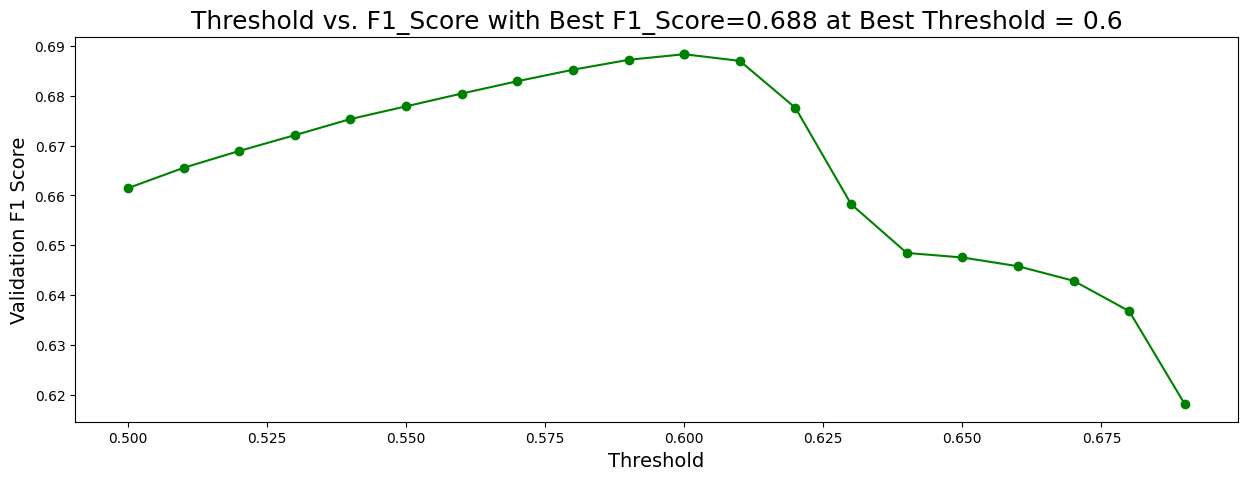

When using optimal threshold = 0.60...
Q1: F1 = 0.6551947652725485
Q2: F1 = 0.49464879356568364
Q3: F1 = 0.4829379622111523
Q4: F1 = 0.6563775893397941
Q5: F1 = 0.636848312171115
Q6: F1 = 0.60179457403879
Q7: F1 = 0.6022532554554538
Q8: F1 = 0.568779885974239
Q9: F1 = 0.6151306527322318
Q10: F1 = 0.5947148932217895
Q11: F1 = 0.6022074354449949
Q12: F1 = 0.4635391961016132
Q13: F1 = 0.46662257743380586
Q14: F1 = 0.6219584254964344
Q15: F1 = 0.5929757645067109
Q16: F1 = 0.47660981447037054
Q17: F1 = 0.4436134428279946
Q18: F1 = 0.557914362156587
==> Overall F1 = 0.6883607610453438
s


In [43]:
for threshold in np.arange(0.5, 0.7, 0.01):
    preds = (oof.values.reshape(-1) > threshold).astype('int')
    m = f1_score(true.values.reshape(-1), preds, average='macro')
    scores.append(m)
    thresholds.append(threshold)
    if m > best_socre:
        best_socre = m
        best_threshold = threshold

plt.figure(figsize=(15, 5))
plt.plot(thresholds, scores, '-o', color='green')
plt.scatter([best_threshold], [best_socre], color='green')
plt.xlabel("Threshold", size=14)
plt.ylabel("Validation F1 Score",size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score={best_socre:.3f} at Best Threshold = {best_threshold:.3}', size=18)
plt.show()

print(f'When using optimal threshold = {best_threshold:.2f}...')
for k in range(18):
    m = f1_score(true[k].values, (oof[k].values > best_threshold).astype('int'), average = 'macro')
    print(f'Q{k+1}: F1 =',m)
m = f1_score(true.values.reshape(-1), (oof.values > best_threshold).reshape(-1).astype('int'), average = 'macro')
print('==> Overall F1 =', m)
print('s')

# Submission Jo Wilder

In [44]:
import jo_wilder_310 as jo_wilder
env = jo_wilder.make_env()
iter_test = env.iter_test()

In [45]:
models_list = [[CatBoostClassifier().load_model(
    f"fold{fold}_q{q}.cbm"
) for fold in range(2)] for q in range(1, 19)]

In [46]:
limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}

for test, sample_submission in iter_test:
    test = test.sort_values(by = 'index')
    sample_submission['q'] = sample_submission.session_id.apply(lambda x: x.split("_q")[1]).astype(int)
    sample_submission = sample_submission.sort_values(by = 'q')
    sample_submission.drop('q',axis=1,inplace=True)
    
    sample_submission['question'] = [int(label.split('_')[1][1:]) for label in sample_submission['session_id']]
    grp = test.level_group.values[0]
    session_id = test.session_id.values[0]
    a,b = limits[grp]    
        
    df = (pl.from_pandas(test)
          .drop(["fullscreen", "hq", "music"])
          .with_columns(columns))
    df = feature_engineer(df, grp, use_extra=True, feature_suffix='')
    df = time_feature(df)
    
    fold = 1
    preds = []
    a,b = limits[grp]
    
    for q in range(a, b):
        print("Question: ",q)
        FEATURES = importance_dict[str(q)]
        model = models_list[q-1][fold]
        
        pred = model.predict_proba(df[FEATURES].astype(np.float32))[:,1]
        mask = sample_submission.question == q 
        sample_submission.loc[mask, 'correct'] = (pred > best_threshold).astype('int') 

    env.predict(sample_submission[['session_id', 'correct']])

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
Question:  1
Question:  2
Question:  3
Question:  4
Question:  5
Question:  6
Question:  7
Question:  8
Question:  9
Question:  10
Question:  11
Question:  12
Question:  13
Question:  14
Question:  15
Question:  16
Question:  17
Question:  18
Question:  1
Question:  2
Question:  3
Question:  4
Question:  5
Question:  6
Question:  7
Question:  8
Question:  9
Question:  10
Question:  11
Question:  12
Question:  13
Question:  14
Question:  15
Question:  16
Question:  17
Question:  18
Question:  1
Question:  2
Question:  3
Question:  4
Question:  5
Question:  6
Question:  7
Question:  8
Question:  9
Question:  10
Question:  11
Question:  12
Question:  13
Question:  14
Question:  15
Question:  16
Question:  17
Question:  18


In [47]:
sub = pd.read_csv('submission.csv')
print("Shape: ",sub.shape)
sub1 = sub[sub["session_id"].str.contains("session_id") == False]
print("Shape: ",sub1.shape)
sub1["correct"] = pd.to_numeric(sub1["correct"], downcast="float")
print("==> Test MEAN: ",np.mean(sub1["correct"]))
sub1.head(18)

Shape:  (54, 2)
Shape:  (54, 2)
==> Test MEAN:  0.6481481


,session_id,correct
0,20090109393214576_q1,1.0
1,20090109393214576_q2,1.0
2,20090109393214576_q3,1.0
3,20090109393214576_q4,1.0
4,20090109393214576_q5,0.0
5,20090109393214576_q6,1.0
6,20090109393214576_q7,1.0
7,20090109393214576_q8,0.0
8,20090109393214576_q9,1.0
9,20090109393214576_q10,0.0
